## Notebook 4: Deep Learning | Grupo 5  

#### Grupo 5 | Joana Gabriel pg42870; Maria Couto pg44380 ; Sara Boaventura pg44381

Nesta etape o objetivo é utilizar métodos de deep learning nos nosso dados e comparar os resultados, tanto entre si bem como com os da etapa anterior.

Ao fazer uma pesquisa sobre que metodos de deep learning eram mais adequados usar nos nossos dados, chegamos à conclusão que o melhor seria fazer dnn (*Deep neural networks*) simples com os dados das features que tinhamos das etapas anteriores (ficheiro Etapa_3) e de seguida faltar a processar as sequencias iniciais com one hot encoding e usar os metodos cnn (*Convolutional neural network*) e lstm (*Long short-term memory*).

In [1]:
import sklearn
import pandas as pd
import re
import tensorflow as tf
import numpy as np

from numpy import array, argmax
from Bio import SeqIO
from Bio.Data import IUPACData
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import make_scorer
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import train_test_split
from propythia.deep_ml import DeepML

De modo a conseguirmos analisar os nossos dados com os metodos de deep learning temos de começar pelos ficheiros fasta fornecidos no inicio (e não os que ja temos com as features calculadas). Assim fomos buscar esses ficheiros criar um dataframe com a sequencia e a label de 1 se for uma proteina SNARE e 0 se for uma proteina NON_SNARE.

In [2]:
#creates a dici with the seq id as key and the sequence as values 
non_snare_cv_seqs = {}
for seq_record in SeqIO.parse("non_snare_cv.fasta","fasta"):
    name, sequence = seq_record.id, seq_record.seq
    non_snare_cv_seqs[name] = str(sequence)
# creates a df with the sequence and the label
non_snares_cv_df = pd.DataFrame.from_dict(non_snare_cv_seqs, orient='index', columns=['sequence'])
non_snares_cv_df['label'] = 0

In [3]:
#creates a dici with the seq id as key and the sequence as values
snare_cv_seqs = {}
for seq_record in SeqIO.parse("snare_cv.fasta","fasta"):
    name, sequence = seq_record.id, seq_record.seq
    snare_cv_seqs[name] = str(sequence)
# creates a df with the sequence and the label
snare_cv_df = pd.DataFrame.from_dict(snare_cv_seqs, orient='index', columns=['sequence'])
snare_cv_df['label'] = 1

In [4]:
#creates a dici with the seq id as key and the sequence as values
non_snare_ind_seqs = {}
for seq_record in SeqIO.parse("non_snare_ind.fasta","fasta"):
    name, sequence = seq_record.id, seq_record.seq
    non_snare_ind_seqs[name] = str(sequence)
# creates a df with the sequence and the label
non_snare_ind_df = pd.DataFrame.from_dict(non_snare_ind_seqs, orient='index', columns=['sequence'])
non_snare_ind_df['label'] = 0

In [5]:
#creates a dici with the seq id as key and the sequence as values
snare_ind_seqs = {}
for seq_record in SeqIO.parse("snare_ind.fasta","fasta"):
    name, sequence = seq_record.id, seq_record.seq
    snare_ind_seqs[name] = str(sequence)
# creates a df with the sequence and the label
snare_ind_df = pd.DataFrame.from_dict(snare_ind_seqs, orient='index',  columns=['sequence'])
snare_ind_df['label'] = 1

De modo a proceder à analise dos dados é necessário criar dois datasets: o de treino e o de teste. Em cada um deles temos de juntar as snares com as non_snares, daí o label ser importante. Para o dataset de teste juntou-se os df das snares_ind e non_snares_ind e para os de treino os df das snares_cv e non_snares_cv

In [6]:
#juntar os datasets
dataset_test = pd.concat([snare_ind_df, non_snare_ind_df])
dataset_train = pd.concat([snare_cv_df, non_snares_cv_df])

Para iniciar os metodos de deep learning (cnn e lstm) a primeira coisa a ser feita é transformar as sequencias em one hot enconding

In [8]:
# funcao que devolve as sequencias no modo one hot encoding
def encode_sequence(sequences, seq_len, padding_truncating='post'):
    # define a mapping of chars to integers
    alphabet = "XARNDCEQGHILKMFPSTWYV"
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    int_to_char = dict((i, c) for i, c in enumerate(alphabet))

    sequences_integer_ecoded = []
    for seq in sequences:
        # if 'X' not in alphabet:
        seq = seq.replace('X', '')  # unknown character eliminated
        seq = seq.replace('B', '')
        seq = seq.replace('J', '')
        seq = seq.replace('U', '')
        # integer encode input data
        integer_encoded = [char_to_int[char] for char in seq]
        sequences_integer_ecoded.append(integer_encoded)
    list_of_sequences_integer = pad_sequences(sequences_integer_ecoded, maxlen=seq_len, dtype='int32',
                                              padding=padding_truncating, truncating=padding_truncating, value=0.0)
    list_of_sequences_aa = []
    for seq in list_of_sequences_integer:
        pad_aa_list = [int_to_char[char] for char in seq]
        pad_aa = ''.join(pad_aa_list)
        list_of_sequences_aa.append(pad_aa)


    # one hot encoding
    fps_x_2d = to_categorical(list_of_sequences_integer)  # shape (samples, 1000,20)
    # shape_hot = len(alphabet) * seq_len  # 20000
    # fps_x_1d = pd.DataFrame(fps_x_2d.reshape(fps_x_2d.shape[0], shape_hot))  # shape (samples, 20000)
    # return fps_x_1d
    return fps_x_2d

Para os dados de treino, temos de usar a função anterior e obtemos os valores de x, para os valores de y, estes correspondem aos labels e para isso já não é nessecessário recorrer à função anterior mas sim ao LabelEncoder()

In [9]:
# obtencao dos valores de x_train
fps_x_train = encode_sequence(sequences = dataset_train['sequence'], seq_len=600, padding_truncating='post')
print(fps_x_train.shape) 

(44648, 600, 21)


Corresponde as 44648 sequencias que existem no dataset de treino, o tamanho da sequencia e ao tamanho do alfabeto. Ou seja fps_x_train é um array com 3 dimensoes, que corresponde a uma lista tamanho 44648 (que sao as sequencias), em que cada uma delas tem 600 listas que correspondem às primeiras 600 posições das sequencias em que cada uma destas tem um tamanho de 21 que corresponde ao tamanho do alfabeto das proteinas, assim dependendo da posicao onde aparece o numero 1 nesta ultima lista corresponde a um aminoacido. 

In [10]:
# obtencao dos valores de y_train
fps_y_train = dataset_train['label']
encoder = LabelEncoder()
encoder.fit(fps_y_train)
fps_y_encoded_train = encoder.transform(fps_y_train)
fps_y_encoded_train #corresponde as labels 

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

Para os dados de teste é necessário realizar o mesmo procedimento que para os dados anteriores

In [11]:
# obtencao dos valores de x_test
fps_x_test = encode_sequence(sequences = dataset_test['sequence'], seq_len=600, padding_truncating='post')
print(fps_x_test.shape) #temos 8930 sequencias

(8930, 600, 21)


In [12]:
# obtencao dos valores de y_test
fps_y_test = dataset_test['label']
encoder = LabelEncoder()
encoder.fit(fps_y_test)
fps_y_encoded_test = encoder.transform(fps_y_test)
fps_y_encoded_test

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

No entanto ainda é necessário ter dados para validação, esses dados foram obtidos ao dividir os dados de treino, em dados de treino e dados de validação.

In [13]:
# divisao dos dados de treino em dados de treino e validacao
x_train, x_dval, y_train, y_dval = train_test_split(fps_x_train, fps_y_encoded_train, test_size=0.25, random_state=42,
                                                        stratify=fps_y_encoded_train, shuffle=True)

In [14]:
print(x_train.shape) # cocorresponde as 33486 sequencias que existe nos dados de treino
print(x_dval.shape) # cocorresponde as 11162 sequencias que existe nos dados de validacao

(33486, 600, 21)
(11162, 600, 21)


In [15]:
print(y_train.shape) # corresponde as labels das 33486 sequencias que existe nos dados de treino
print(y_dval.shape) # corresponde as labels das 11162 sequencias que existe nos dados de validacao

(33486,)
(11162,)


### LSTM

In [16]:
from tensorflow.keras import utils
fps_y_bin = utils.to_categorical(fps_y_encoded_train)
final_units = fps_y_bin.shape[1]

In [17]:
# objeto deepML, com 5 epochs 
dl = DeepML(x_train, y_train, fps_x_test, fps_y_encoded_test,
                 number_classes=final_units, problem_type='binary',
                 x_dval=x_dval, y_dval=y_dval,
                 model=None,
                 epochs=5, batch_size=512, callbacks=None,
                 reduce_lr=True, early_stopping=True, checkpoint=True, tensorboard=False,
                 early_stopping_patience=10, reduce_lr_patience=50, reduce_lr_factor=0.2, reduce_lr_min=0.00001,
                 path='', report_name=None, verbose=1,  validation_split=0.1, shuffle=True, class_weights=None)


In [18]:
strategy = tf.distribute.MirroredStrategy()
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dropout, Bidirectional
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, GRU, BatchNormalization, Masking
from tensorflow.keras import regularizers

# função que cria o modelo lstm 
def lstm_simple(input_dim, timestep = 21,
                  optimizer='Adam',
                  lstm_layers=(64,32), # numero de layers 
                  bidirectional = True,
                  activation='tanh',
                  recurrent_activation='sigmoid',
                  dropout_rate=(0.3, 0.3, 0.3),
                  l1=1e-5, l2=1e-4,
                  dense_layers=(32,16),
                  dropout_rate_dense=(0.1, 0.1),
                  dense_activation="relu", loss='binary_crossentropy',final_activation='sigmoid', metric ='accuracy'):
    with strategy.scope():
        model = Sequential()
        # input dim timesteps = seq size , features. 21 features per character
        model.add(Input(shape=(input_dim, timestep,), dtype='float32', name='main_input'))
        # add initial dropout

        # model.add(Masking(mask_value=0, input_shape=(n_in, 1)))
        model.add(Masking(mask_value=0))
        if bidirectional:
            for layer in range(len(lstm_layers) - 1):
                    model.add(Bidirectional(
                        LSTM(units=lstm_layers[layer], return_sequences=True, activation=activation,
                             recurrent_activation=recurrent_activation,
                             kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                             dropout=dropout_rate[layer], recurrent_dropout=0.0), input_shape=(input_dim, 21,)))

            # add last lstm1 layer
            model.add(Bidirectional(
                LSTM(units=lstm_layers[-1], return_sequences=False,
                     activation=activation, recurrent_activation=recurrent_activation,
                     kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                     dropout=dropout_rate[-1], recurrent_dropout=0.0)))
        else:
            for layer in range(len(lstm_layers) - 1):
                model.add(LSTM(units=lstm_layers[layer], return_sequences=True, activation=activation,
                               recurrent_activation=recurrent_activation,
                               kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                               dropout=dropout_rate[layer], recurrent_dropout=0.0))

            # add last lstm1 layer
            model.add(
                LSTM(units=lstm_layers[-1], return_sequences=False,
                     activation=activation, recurrent_activation=recurrent_activation,
                     kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                     dropout=dropout_rate[-1], recurrent_dropout=0.0))
        # add denses
        for layer in range(len(dense_layers)):
            model.add(Dense(units=dense_layers[layer], activation=dense_activation,
                            kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2)))
            model.add(BatchNormalization())
            model.add(Dropout(dropout_rate_dense[layer]))

        # Add Classification Dense, Compile model and make it ready for optimization
        model.add(Dense(1, activation=final_activation))
        model.compile(loss=loss, optimizer=optimizer, metrics=[metric])
        print(model.summary())
        return model


Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op NoOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op NoOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op NoOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Qr in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DiagPart in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Sign in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Transpose in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Reshape in device /job:localhost/replica:0/task:0/device:CPU:

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op NoOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op NoOp in device /job:localhost/replica:0/t

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op NoOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op NoOp in device /job:localhost/r

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op NoOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op NoOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op NoOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/repli

Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op NoOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op NoOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op NoOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:

Executing op __inference_train_function_29475 in device /job:localhost/replica:0/task:0/device:CPU:0
 5/59 [=>............................] - ETA: 24:18 - loss: 0.8966 - accuracy: 0.5410Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_29475 in device /job:localhost/replica:0/task:0/device:CPU:0
 6/59 [==>...........................] - ETA: 24:41 - loss: 0.8962 - accuracy: 0.5449Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_29475 in device /job:localhost/replica:0/task:0/device:CPU:0
 7/59 [==>...........................] - ETA: 24:53 -

24/59 [===========>..................] - ETA: 25:12 - loss: 0.7456 - accuracy: 0.6448Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_29475 in device /job:localhost/replica:0/task:0/device:CPU:0
25/59 [===========>..................] - ETA: 24:52 - loss: 0.7399 - accuracy: 0.6490Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_29475 in device /job:localhost/replica:0/task:0/device:CPU:0
26/59 [============>.................] - ETA: 24:28 - loss: 0.7367 - accuracy: 0.6515Executing op ReadVariableOp in device /job:localhost/replica:0/task:0

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_29475 in device /job:localhost/replica:0/task:0/device:CPU:0
44/59 [=====================>........] - ETA: 12:58 - loss: 0.6706 - accuracy: 0.6978Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_29475 in device /job:localhost/replica:0/task:0/device:CPU:0
45/59 [=====================>........] - ETA: 12:10 - loss: 0.6666 - accuracy: 0.7005Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0


Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/repli

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/tas

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_29475 in device /job:localhost/replica:0/task:0/device:CPU:0
17/59 [=======>......................] - ETA: 38:45 - loss: 0.4510 - accuracy: 0.8449Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_29475 in device /job:localhost/replica:0/task:0/device:CPU:0
18/59 [========>.....................] - ETA: 38:02 - loss: 0.4512 - accuracy: 0.8443Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0


36/59 [=================>............] - ETA: 22:53 - loss: 0.4412 - accuracy: 0.8482Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_29475 in device /job:localhost/replica:0/task:0/device:CPU:0
37/59 [=================>............] - ETA: 21:56 - loss: 0.4396 - accuracy: 0.8488Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_29475 in device /job:localhost/replica:0/task:0/device:CPU:0
38/59 [==================>...........] - ETA: 21:01 - loss: 0.4391 - accuracy: 0.8492Executing op ReadVariableOp in device /job:localhost/replica:0/task:0

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_29475 in device /job:localhost/replica:0/task:0/device:CPU:0
56/59 [===========================>..] - ETA: 3:08 - loss: 0.4214 - accuracy: 0.8570Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_29475 in device /job:localhost/replica:0/task:0/device:CPU:0
57/59 [===========================>..] - ETA: 2:05 - loss: 0.4213 - accuracy: 0.8572Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Ex

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/repli

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/repli

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
59/59 [==============================] - 3739s 64s/step - loss: 0.4211 - accuracy: 0.8573 - val_loss: 0.5693 - val_accuracy: 0.8629 - lr: 0.0010
Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/ta

15/59 [======>.......................] - ETA: 51:11 - loss: 0.3762 - accuracy: 0.8759Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_29475 in device /job:localhost/replica:0/task:0/device:CPU:0
16/59 [=======>......................] - ETA: 50:07 - loss: 0.3748 - accuracy: 0.8763Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_29475 in device /job:localhost/replica:0/task:0/device:CPU:0
17/59 [=======>......................] - ETA: 49:01 - loss: 0.3731 - accuracy: 0.8774Executing op ReadVariableOp in device /job:localhost/replica:0/task:0

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_29475 in device /job:localhost/replica:0/task:0/device:CPU:0
35/59 [================>.............] - ETA: 28:43 - loss: 0.3723 - accuracy: 0.8770Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_29475 in device /job:localhost/replica:0/task:0/device:CPU:0
36/59 [=================>............] - ETA: 27:33 - loss: 0.3719 - accuracy: 0.8774Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0


54/59 [==========================>...] - ETA: 6:07 - loss: 0.3709 - accuracy: 0.8774Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_29475 in device /job:localhost/replica:0/task:0/device:CPU:0
55/59 [==========================>...] - ETA: 4:53 - loss: 0.3714 - accuracy: 0.8771Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_29475 in device /job:localhost/replica:0/task:0/device:CPU:0
56/59 [===========================>..] - ETA: 3:40 - loss: 0.3712 - accuracy: 0.8772Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/de

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/repli

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
59/59 [==============================] - 4388s 74s/step - loss: 0.3704 - accuracy: 0.8778 - val_loss: 0.4237 - val_accuracy: 0.8797 - l

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_29475 in device /job:localhost/replica:0/task:0/device:CPU:0
14/59 [======>.......................] - ETA: 2:10:40 - loss: 0.3643 - accuracy: 0.8770Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_29475 in device /job:localhost/replica:0/task:0/device:CPU:0
15/59 [======>.......................] - ETA: 2:09:05 - loss: 0.3625 - accuracy: 0.8771Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CP

Executing op __inference_train_function_29475 in device /job:localhost/replica:0/task:0/device:CPU:0
33/59 [===============>..............] - ETA: 1:10:41 - loss: 0.3438 - accuracy: 0.8868Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_29475 in device /job:localhost/replica:0/task:0/device:CPU:0
34/59 [================>.............] - ETA: 1:06:57 - loss: 0.3429 - accuracy: 0.8872Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_29475 in device /job:localhost/replica:0/task:0/device:CPU:0
35/59 [================>.............] - ETA: 1:0

52/59 [=========================>....] - ETA: 15:37 - loss: 0.3428 - accuracy: 0.8886Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_29475 in device /job:localhost/replica:0/task:0/device:CPU:0
53/59 [=========================>....] - ETA: 13:17 - loss: 0.3429 - accuracy: 0.8886Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_29475 in device /job:localhost/replica:0/task:0/device:CPU:0
54/59 [==========================>...] - ETA: 11:00 - loss: 0.3424 - accuracy: 0.8890Executing op ReadVariableOp in device /job:localhost/replica:0/task:0

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_36979 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/repli

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_29475 in device /job:localhost/replica:0/task:0/device:CPU:0
12/59 [=====>........................] - ETA: 1:04:14 - loss: 0.3151 - accuracy: 0.9017Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_29475 in device /job:localhost/replica:0/task:0/device:CPU:0
13/59 [=====>........................] - ETA: 1:02:43 - loss: 0.3159 - accuracy: 0.9014Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_29475 in device /job:localhost/re

31/59 [==============>...............] - ETA: 39:05 - loss: 0.3396 - accuracy: 0.8889Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_29475 in device /job:localhost/replica:0/task:0/device:CPU:0
32/59 [===============>..............] - ETA: 37:46 - loss: 0.3402 - accuracy: 0.8884Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_29475 in device /job:localhost/replica:0/task:0/device:CPU:0
33/59 [===============>..............] - ETA: 36:25 - loss: 0.3395 - accuracy: 0.8887Executing op ReadVariableOp in device /job:localhost/replica:0/task:0

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_29475 in device /job:localhost/replica:0/task:0/device:CPU:0
51/59 [========================>.....] - ETA: 11:26 - loss: 0.3450 - accuracy: 0.8848Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_29475 in device /job:localhost/replica:0/task:0/device:CPU:0
52/59 [=========================>....] - ETA: 10:01 - loss: 0.3444 - accuracy: 0.8848Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0


Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_36979 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_36979 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_36979 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteMultiDeviceIterator in device /job:localhost/re

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/repli

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost

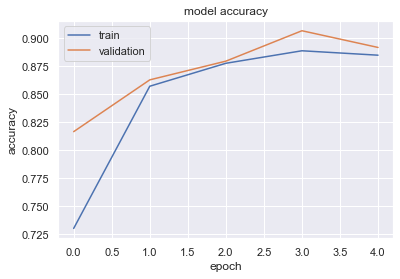

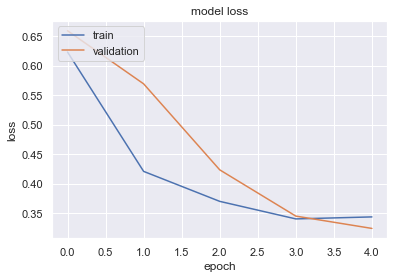

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


<Figure size 432x288 with 0 Axes>

In [19]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.FATAL)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# run model lstm
lstm = KerasClassifier(build_fn=lstm_simple,input_dim=600, timestep = 21)
model = dl.run_model(model=lstm)

In [20]:
# scores lstm
score = dl.model_simple_evaluate()
scores, report, cm, cm2 = dl.model_complete_evaluate()

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Rea

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_36979 in device /job:localhost/replica:0/task:0/device:CPU:0
  8/280 [..............................] - ETA: 1:02 - loss: 1.0341 - accuracy: 0.4023Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_36979 in device /job:localhost/replica:0/task:0/device:CPU:0
  9/280 [..............................] - ETA: 1:02 - loss: 0.9683 - accuracy: 0.4549Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0


 27/280 [=>............................] - ETA: 58s - loss: 1.0566 - accuracy: 0.3947Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_36979 in device /job:localhost/replica:0/task:0/device:CPU:0
 28/280 [==>...........................] - ETA: 57s - loss: 1.0597 - accuracy: 0.3951Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_36979 in device /job:localhost/replica:0/task:0/device:CPU:0
 29/280 [==>...........................] - ETA: 57s - loss: 1.0415 - accuracy: 0.4106Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/d

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_36979 in device /job:localhost/replica:0/task:0/device:CPU:0
 47/280 [====>.........................] - ETA: 53s - loss: 0.9437 - accuracy: 0.4727Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_36979 in device /job:localhost/replica:0/task:0/device:CPU:0
 48/280 [====>.........................] - ETA: 53s - loss: 0.9435 - accuracy: 0.4701Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_36979 in device /job:localhost/replica:0

 66/280 [======>.......................] - ETA: 49s - loss: 0.8789 - accuracy: 0.5175Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_36979 in device /job:localhost/replica:0/task:0/device:CPU:0
 67/280 [======>.......................] - ETA: 48s - loss: 0.8800 - accuracy: 0.5154Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_36979 in device /job:localhost/replica:0/task:0/device:CPU:0
 68/280 [======>.......................] - ETA: 48s - loss: 0.8880 - accuracy: 0.5092Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/d

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_36979 in device /job:localhost/replica:0/task:0/device:CPU:0
 86/280 [========>.....................] - ETA: 44s - loss: 0.8227 - accuracy: 0.5367Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_36979 in device /job:localhost/replica:0/task:0/device:CPU:0
 87/280 [========>.....................] - ETA: 44s - loss: 0.8191 - accuracy: 0.5377Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_36979 in device /job:localhost/replica:0

105/280 [==========>...................] - ETA: 40s - loss: 0.7814 - accuracy: 0.5485Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_36979 in device /job:localhost/replica:0/task:0/device:CPU:0
106/280 [==========>...................] - ETA: 40s - loss: 0.7791 - accuracy: 0.5492Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_36979 in device /job:localhost/replica:0/task:0/device:CPU:0
107/280 [==========>...................] - ETA: 39s - loss: 0.7768 - accuracy: 0.5511Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/d

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_36979 in device /job:localhost/replica:0/task:0/device:CPU:0
125/280 [============>.................] - ETA: 35s - loss: 0.7903 - accuracy: 0.5440Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_36979 in device /job:localhost/replica:0/task:0/device:CPU:0
126/280 [============>.................] - ETA: 35s - loss: 0.7873 - accuracy: 0.5474Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_36979 in device /job:localhost/replica:0

144/280 [==============>...............] - ETA: 31s - loss: 0.7509 - accuracy: 0.5870Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_36979 in device /job:localhost/replica:0/task:0/device:CPU:0
145/280 [==============>...............] - ETA: 31s - loss: 0.7479 - accuracy: 0.5899Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_36979 in device /job:localhost/replica:0/task:0/device:CPU:0
146/280 [==============>...............] - ETA: 30s - loss: 0.7451 - accuracy: 0.5918Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/d

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_36979 in device /job:localhost/replica:0/task:0/device:CPU:0
164/280 [================>.............] - ETA: 26s - loss: 0.7016 - accuracy: 0.6301Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_36979 in device /job:localhost/replica:0/task:0/device:CPU:0
165/280 [================>.............] - ETA: 26s - loss: 0.6988 - accuracy: 0.6324Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_36979 in device /job:localhost/replica:0

183/280 [==================>...........] - ETA: 22s - loss: 0.6611 - accuracy: 0.6646Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_36979 in device /job:localhost/replica:0/task:0/device:CPU:0
184/280 [==================>...........] - ETA: 22s - loss: 0.6591 - accuracy: 0.6661Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_36979 in device /job:localhost/replica:0/task:0/device:CPU:0
185/280 [==================>...........] - ETA: 21s - loss: 0.6584 - accuracy: 0.6671Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/d

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_36979 in device /job:localhost/replica:0/task:0/device:CPU:0
203/280 [====================>.........] - ETA: 17s - loss: 0.6276 - accuracy: 0.6933Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_36979 in device /job:localhost/replica:0/task:0/device:CPU:0
204/280 [====================>.........] - ETA: 17s - loss: 0.6257 - accuracy: 0.6949Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_36979 in device /job:localhost/replica:0

222/280 [======================>.......] - ETA: 13s - loss: 0.6026 - accuracy: 0.7152Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_36979 in device /job:localhost/replica:0/task:0/device:CPU:0
223/280 [======================>.......] - ETA: 13s - loss: 0.6016 - accuracy: 0.7164Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_36979 in device /job:localhost/replica:0/task:0/device:CPU:0
224/280 [=======================>......] - ETA: 12s - loss: 0.6001 - accuracy: 0.7176Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/d

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_36979 in device /job:localhost/replica:0/task:0/device:CPU:0
242/280 [========================>.....] - ETA: 8s - loss: 0.5778 - accuracy: 0.7361Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_36979 in device /job:localhost/replica:0/task:0/device:CPU:0
243/280 [=========================>....] - ETA: 8s - loss: 0.5765 - accuracy: 0.7370Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_36979 in device /job:localhost/replica:0/t

261/280 [==========================>...] - ETA: 4s - loss: 0.5589 - accuracy: 0.7513Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_36979 in device /job:localhost/replica:0/task:0/device:CPU:0
262/280 [===========================>..] - ETA: 4s - loss: 0.5577 - accuracy: 0.7523Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_36979 in device /job:localhost/replica:0/task:0/device:CPU:0
263/280 [===========================>..] - ETA: 3s - loss: 0.5567 - accuracy: 0.7530Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/devi

('test loss, test acc:', [0.543973982334137, 0.764501690864563])
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/

Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/

Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/

Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ConcatV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/devic

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/

Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/

Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/

Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_48426 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ConcatV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0


In [21]:
print(score)
print(scores)
print(report)
print(cm)

[0.543973982334137, 0.764501690864563]
{'Accuracy': 0.7645016797312431, 'MCC': 0.5710169498218859, 'log_loss': 0.4992779150199508, 'f1 score': 0.7098910194509588, 'roc_auc': 0.7645016797312431, 'Precision': array([0.5       , 0.92420977, 1.        ]), 'Recall': array([1.       , 0.5762598, 0.       ]), 'sn': 0.5762597984322508, 'sp': 0.9527435610302352}
              precision    recall  f1-score   support

           0       0.69      0.95      0.80      4465
           1       0.92      0.58      0.71      4465

    accuracy                           0.76      8930
   macro avg       0.81      0.76      0.76      8930
weighted avg       0.81      0.76      0.76      8930

[[4254  211]
 [1892 2573]]


Com a observação dos resultados do método de deep learning cnn é possível concluir que:

* No gráfico **loss vs epoch** observa-se que a função de treino e a função de validação diminuem ao longo da experiência. Verifica-se um pico na função de validação na epoch 3 em accuracy em 90%.


* No gráfico **accuracy vs epoch** pode-se observar que à medida que o número de epochs aumenta a accuracy aumenta no modelo de treino e de validação. 


* O valor de **MCC** obtido foi de 0.571, ou seja, um valor ainda afastado de 1, podendo-se considerar uma má previsão do modelo. 


* O valo de **score** é 76,450%.


* O valor de **accuracy** é de 76,45%.   


* Obteve-se um valor de **F1 score** de 0.719, sendo este próximo de 1 pode-se concluir que um bom score. 


* O valor de **AUC** foi de 0.765, podendo se considerar um modelo um classificador mediano de proteinas snares e non_snares. 

O método de deep learning LSTM não foi bem conseguido, isto porque o valor da accuracy e das métricas de erros não obtiveram bons resultados. Pode ser explicado pelo baixo número de epochs e número de layers utilizadas, no entanto o grupo tentou correr o modelo com 30 epochs mas não foi conseguido pois o método à elevada capacidade de processamento necessária para tal. 

### CNN

In [26]:
# objeto deepML, com 30 epochs com early stopping patience de 10
# se a accuracy não variar significativamente durante 10 epochs o modelo para automaticamente 
dl = DeepML(x_train, y_train, fps_x_test, fps_y_encoded_test,
            number_classes=final_units, problem_type='binary',
            x_dval=x_dval, y_dval=y_dval,
            model=None,
            epochs=30, batch_size=512, callbacks=None,
            reduce_lr=True, early_stopping=True, checkpoint=True, tensorboard=False,
            early_stopping_patience=10, reduce_lr_patience=50, reduce_lr_factor=0.2, reduce_lr_min=0.00001,
            path='', report_name=None, verbose=1,  validation_split=0.1, shuffle=True, class_weights=None)


cnn 1D model
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op NoOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op NoOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op NoOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhost/rep

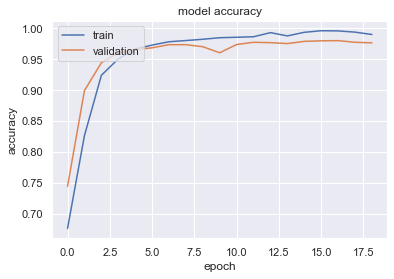

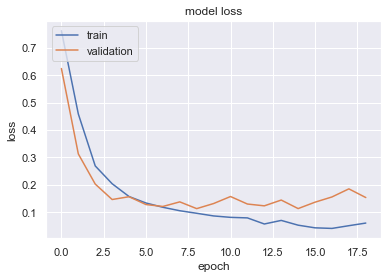

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
Finished 'run_cnn_1D' in 14266.8103 secs


<Figure size 432x288 with 0 Axes>

In [27]:
# modelo cnn 1d 
cnn1d_simple = dl.run_cnn_1D(input_dim=(600,21),
                             optimizer='Adam',
                             filter_count=(64,128,256),  # define number layers
                             padding='same',
                             strides=1,
                             kernel_size=(16,),  # list of kernel sizes per layer. if number will be the same in all numbers
                             cnn_activation='relu',
                             kernel_initializer='glorot_uniform',
                             dropout_cnn=(0.0, 0.2, 0.2),   # list of dropout per cnn layer. if number will be the same in all numbers
                             max_pooling=(True,),
                             pool_size=(2,), strides_pool=1,
                             data_format_pool='channels_first',
                             dense_layers=(32,16),
                             dense_activation="relu",
                             dropout_rate=(0.3,0.3),
                             l1=1e-5, l2=1e-4,
                             loss_fun = 'binary_crossentropy', activation_fun = 'sigmoid',
                             cv=None, optType=None, param_grid=None, n_iter_search=3, n_jobs=1,
                             scoring=make_scorer(matthews_corrcoef))

In [28]:
# run model cnn 
score_cnn = dl.model_simple_evaluate()
scores, report, cm, cm2 = dl.model_complete_evaluate()

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Rea

In [29]:
# scores cnn 
print(score_cnn)
print(scores)
print(report)
print(cm)

[0.6611456274986267, 0.9100784063339233]
{'Accuracy': 0.9100783874580067, 'MCC': 0.8302766302814504, 'log_loss': 0.6403844405159228, 'f1 score': 0.9024893746205221, 'roc_auc': 0.9100783874580067, 'Precision': array([0.5       , 0.98567639, 1.        ]), 'Recall': array([1.        , 0.83225084, 0.        ]), 'sn': 0.8322508398656215, 'sp': 0.9879059350503919}
              precision    recall  f1-score   support

           0       0.85      0.99      0.92      4465
           1       0.99      0.83      0.90      4465

    accuracy                           0.91      8930
   macro avg       0.92      0.91      0.91      8930
weighted avg       0.92      0.91      0.91      8930

[[4411   54]
 [ 749 3716]]


Com a observação dos resultados do método de deep learning cnn é possível concluir que:

* No gráfico **loss vs epoch** observa-se que a função de treino diminui ao longo da experiência, ao passo que a função de validação diminui até a um ponto (ponto de inflexão) e depois aumenta. Isto pode ser explicado pelo facto de o treino ficar interrompido e ocorrer overfitting. 


* No gráfico **accuracy vs epoch** pode-se observar que à medida que o número de epochs aumenta a accuracy aumenta exponencialmente no modelo de treino e de validação. No entanto, a accuracy da função de validação tem pior performance que a accuracy da função de treino, o que seria de esperar visto que os dados de treino são dados com os quais o modelo já está familiarizado em oposição aos dados de validação que são novos para o modelo. 


* O valor de **MCC** obtido foi de 0.830, ou seja, um valor próximo de 1, podendo-se considerar assim uma boa previsão do modelo. 


* O valo de **score** é 66%.


* O valor de **accuracy** é de 91,01%.   


* Obteve-se um valor de **F1 score** de 0.902, sendo este próximo de 1 pode-se concluir que um bom score. 


* O valor de **AUC** foi de 0.910, podendo se considerar um modelo um bom classificador de proteinas snares e non_snares. 




Em conclusão, comparando os métodos de deep learning analisados, pode-se concluir que o método CNN é que apresenta melhores, isto é melhor score e accuracy, resultados comparando com o método dnn e LSTM. Pode-se comprovar pela literatura que o modelo dnn não seria o mais indicado para a classificação de proteínas, como se veio a comprovar. Em relação ao método LSTM, poderia ser um bom candidato com um maior número de epochs. 
Posto isto, a conclusão deste trabalho é que o melhor modelo de deep learning obtido foi o CNN para a classificação de proteínas snares e non-snares.  